# Lab 2 - K-Nearest Neighbours   (Moses Mbabaali 4846019) 

This lab is about the implementation and analysis of the KNN algorithm for classification and regression problems

In [32]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
#from matplotlib.mlab import griddata

### Data generation for binary classification

We start generating a training set for binary classification problems. Consider the following function, that generates random 2D points on the plane and assign them a binary label according to their position wrt a linear separator.

The use of the function is the following:
##### X, Y = linearBinaryClass(n, low_D, high_D, m, q)
where
- <b>n</b> is the number of samples to be generated
- <b>low_D</b> and <b>high_D</b> are, respectively, the lower and upper bounds for the domain of the samples
- <b>m, q</b> are the linear function parameters
- <b>X</b>, <b>Y</b>: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)

In [33]:
def linearBinaryClass(n, low_D, high_D, m, q):

    X = np.zeros((n, 2))
    Y = np.zeros(n)
    for i in range(2):
        X[:,i] = np.random.uniform(low_D, high_D, size=n)
        
    Y[X[:,1] - (X[:,0] * m + q) > 0] = 1 
    Y[Y==0] = -1
    
    return X,Y

### Computing the distance between input points

In order to build the KNN estimator we need to resort to a distance function.

Consider a function that computes the euclidean distance between two points...

In [34]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

... and then a function that computes all the distance between two set of points stored in two matrices. The usage is the following:

##### X, Y = allDistances(X1,X2)
where
- <b>X1</b> is a matrix of size [n1xD], where each row is a D-dimensional point
- <b>X2</b> is a matrix of size [n2xD], where each row is a D-dimensional point
- <b>D</b> is a matrix of size [n1xn2], where each element (D)_ij is the distance between points (X_i, X_j)

In [35]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D
    

### Adding noise to the samples

As in Lab 1, we may want to perturb the data with come noise. To this purpose, we use the function <b><i>flipLabels</i></b>, that given an array of binary labels, flips the value of P% of labels (where P is a parameter in input to the function) and returns the obtained flipped array

In [42]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * P / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

### The KNN classifier

We are now ready to use the KNN algorithm to estimate the classification function. The use is as follow:

##### Ypred = kNNClassify(Xtr, Ytr, k, Xte)
where
- <b>Xtr</b> is a matrix of size [ntrxD], where each row is a D-dimensional point (INPUT IN THE <b>TRAINING SET</b>)
- <b>Ytr</b> is an array of size [ntr], where each element is a binary label (OUTPUT IN THE <b>TRAINING SET</b>)
- <b>k</b> is the number of neighbours to be considered
- <b>Xte</b> is a matrix of size [ntexD], where each row is a D-dimensional point (INPUT IN THE <b>TEST SET</b>)
- <b>Ypred</b> is an array of size [nte], where each element is a binary label (ESTIMATED OUTPUT FOR THE <b>TEST SET</b>)

In [43]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0]
    n_test = Xte.shape[0]

    if any(np.abs(Ytr) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    dist = allDistances(Xte, Xtr)

    for idx in range(n_test):
        neigh_indexes = np.argsort(dist[idx, :])[:k]
        avg_neigh = np.mean(Ytr[neigh_indexes])
        Ypred[idx] = np.sign(avg_neigh)

    return Ypred

### Visualizing the separating function

The visualization of the separating function on the training set, i.e. the function estimated by classification algorithm for discriminating between classes, is of benefit for appreciating the behavior of the binary classifier. To visualize the separating function use the following:

##### separatingFkNN(Xtr, Ytr, k)
where
- <b>Xtr</b> is a matrix of size [ntrxD], where each row is a D-dimensional point (INPUT IN THE <b>TRAINING SET</b>)
- <b>Ytr</b> is an array of size [ntr], where each element is a binary label (OUTPUT IN THE <b>TRAINING SET</b>)
- <b>k</b> is the number of neighbours to be considered

In [41]:
import matplotlib.tri as tri
def separatingFkNN(Xtr, Ytr, k):

    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xtr)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 200)
    yi = np.linspace(y.min(), y.max(), 200)
    
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, Ypred)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    plt.scatter(x, y, c=Ytr, marker='o', s=100, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    msg = 'Separating function, k='+str(k);
    plt.title(msg)

### Evaluating the goodness of a classifier

To evaluate how good is the classification function estimated by the KNN, we compare the predicted binary labels and expected (true) ones, with the following function:

##### acc = calcAccuracy(Ypred, Ytrue)
where
- <b>Ypred</b> is an array of size [ntr], where each element is a binary label predicted by the classifier
- <b>Ytrue</b> is an array of size [ntr], where each element is the true binary label
- <b>acc</b> is the percentage of correclty classified elements wrt the total number

In [44]:
def calcAccuracy(Ypred, Ytrue):
    return (np.count_nonzero(Ypred==Ytrue))/len(Ytrue)


### Generate training and test sets, build and evaluate the KNN classifier

With K=1 the accuracy on the test set is  0.95
With K=1 the accuracy on the training set is  1.0


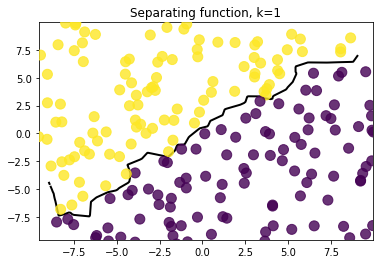

In [252]:
n = 200
D = 2

m = 0.9
q = 0

low_D = -10
high_D = 10

# Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

# Visualize the separating curve for the NN classifier 
separatingFkNN(Xtr, Ytr, 1)

# Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

# Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, 1, Xte)

# Compute the accuracy on the TEST SET
acc = calcAccuracy(Ypred, Yte)

print("With K=1 the accuracy on the test set is ", acc)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, 1, Xtr)
acctr = calcAccuracy(Ypredtr, Ytr)
print("With K=1 the accuracy on the training set is ", acctr)


### Assignment 1

Keeping the parameters of the function and the number of points as in the previous example:

- 1.Generate a training set WITH NOISE (for instance with 10% of flipped labels)
- 2.Visualize the separating curve for the <b>NN</b> classifier 
- 3.Generate a test set WITHOUT NOISE
- 4.Evaluate the NN classifier first on the TRAINING and then on the TEST SET
- 5.Compute the obtained accuracy first on the TRAINING and then on the TEST SET

- Repeat the steps from 1 to 5 with the <b>KNN</b> algorithm, setting for instance K=5

OBSERVE WHAT CHANGES...


In [310]:
def knn1(flip,k):
    """ Takes 2 arguments flip: This is the noise value and k which is the nearest neigbours"""
    n = 200
    D = 2

    m = 0.9
    q = 0

    low_D = -10
    high_D = 10
    
    # Generate a training set WITH NOISE
    Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
    Yn = flipLabels(Ytr, flip)
    
    # Visualize the separating curve for the NN classifier 
    Ytr=Yn
    separatingFkNN(Xtr, Ytr, k)
    
    #Generate a test set WITHOUT NOISE
    Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
    
    # Evaluate the NN classifier on the TEST SET
    Ypred = kNNClassify(Xtr, Ytr, k, Xte)
    
    # Classifier on the training set
    Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
    
    # Compute the accuracy on the TEST SET
    acc = calcAccuracy(Ypred, Yte)
    
    print("With K={} the accuracy on the test set is ".format(k), acc)
    # How the classifier perform on the TRAINING SET instead?
    Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
    acctr = calcAccuracy(Ypredtr, Ytr)
    print("With K={} the accuracy on the training set is ".format(k), acctr)

With K=1 the accuracy on the test set is  0.875
With K=1 the accuracy on the training set is  1.0


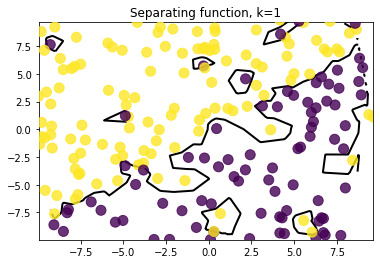

In [311]:
# Question one 
knn1(10,1)

With K=5 the accuracy on the test set is  0.955
With K=5 the accuracy on the training set is  0.88


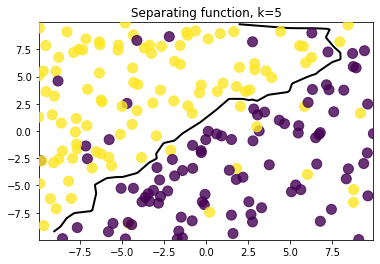

In [312]:
#Question 2 
knn1(10,5)

### Assignment 2

Analyse the performance of the <n>KNN</b> with plots, considering in particular the following:

- <b>SCENARIO 1</b>: Fix the number n of points to 200, fix the amount of noise to 10%, and plot the performance of the KNN classifier on TRAINING an TEST SETS as you increase the value of K

- <b>SCENARIO 2</b>: Fix the number n of points to 200, fix the value of K to a reasonable number of neighbours, and plot the performance of the KNN classifier on TRAINING an TEST SETS as you increase the amount of noise

- <b>SCENARIO 3</b>: Fix noise and K to two reasonable values, fix the number of TEST samples to 300, and plot the performance of the KNN classifier on TRAINING an TEST SETS as you increase the number of TRAINING samples (e.g. from 30 to 300 with steps 30)

In [308]:
#Scenario 1 
def knn2(flip,n,maxk):
    """ Takes 3 arguments, flip which is the percentage of flip or noise, n is number of points maxk-Maximum number 
    of neighbours"""
    n = n
    D = 2

    m = 0.9
    q = 0

    low_D = -10
    high_D = 10
    
    # Generate a training set WITH NOISE
    Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
    Yn = flipLabels(Ytr, flip)
    
    # Visualize the separating curve for the NN classifier 
    Ytr=Yn

    #Test set without noise 
    
    #Yk = flipLabels(Ytr, flip)
    #Yte = Yk
    Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
    
    Ypredt = []
    Ypredtrl = []
    
    for i in range(1,maxk+1):
        print (i)
        # Evaluate the NN classifier on the TEST SET
        Ypred = kNNClassify(Xtr, Ytr, i, Xte)
        
        
        # Classifier on the training set
        Ypredtr = kNNClassify(Xtr, Ytr, i, Xtr)
        
        # Compute the accuracy on the TEST SET
        acc = calcAccuracy(Ypred, Yte)
        Ypredt.append(acc)
        
        print("With K={} the accuracy on the test set is ".format(i), acc)
        # How the classifier perform on the TRAINING SET instead?
        Ypredtr = kNNClassify(Xtr, Ytr, i, Xtr)
        acctr = calcAccuracy(Ypredtr, Ytr)
        Ypredtrl.append(acctr)
        print("With K={} the accuracy on the training set is ".format(i), acctr)
    plt.plot(Ypredt, label='Test Set') 
    plt.plot(Ypredtrl, label='Training Set')
    plt.xlabel('K')
    plt.ylabel('Performance')
    plt.title('Training set and Testing set Performance')
    plt.legend()

1
With K=1 the accuracy on the test set is  0.86
With K=1 the accuracy on the training set is  1.0
2
With K=2 the accuracy on the test set is  0.75
With K=2 the accuracy on the training set is  0.81
3
With K=3 the accuracy on the test set is  0.93
With K=3 the accuracy on the training set is  0.895
4
With K=4 the accuracy on the test set is  0.88
With K=4 the accuracy on the training set is  0.85
5
With K=5 the accuracy on the test set is  0.965
With K=5 the accuracy on the training set is  0.88
6
With K=6 the accuracy on the test set is  0.915
With K=6 the accuracy on the training set is  0.855
7
With K=7 the accuracy on the test set is  0.965
With K=7 the accuracy on the training set is  0.86
8
With K=8 the accuracy on the test set is  0.935
With K=8 the accuracy on the training set is  0.855
9
With K=9 the accuracy on the test set is  0.975
With K=9 the accuracy on the training set is  0.865


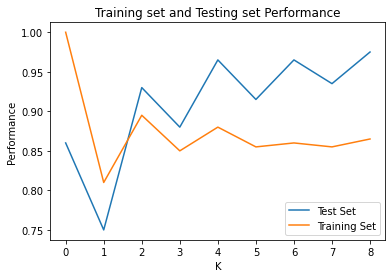

In [307]:
knn2(10,200,9)

In [309]:
#Scenario 2 
def knn3(k,flipmax):
    """ Takes 2 arguments, k (nearest neigbors) is a integer and flipmax (maximum value of flip in %)
    and an integer not greater than 99"""
    n = 200
    D = 2

    m = 0.9
    q = 0

    low_D = -10
    high_D = 10
    
    # Generate a training set WITH NOISE
    Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
    
    #Generate a test set without noise 
    Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
    
    Ypredt = []
    Ypredtrl = []
    
    if flipmax >1 and flipmax <=99:
        for i in range(5,flipmax+6,5):
            print (i)
            Yn = flipLabels(Ytr, i)
            Ytr=Yn
            # Evaluate the NN classifier on the TEST SET
            Ypred = kNNClassify(Xtr, Ytr, k , Xte)
            # Classifier on the training set
            Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
            # Compute the accuracy on the TEST SET
            acc = calcAccuracy(Ypred, Yte)
            Ypredt.append(acc)  
            
            print("With K={} and Noise={} the accuracy on the test set is ".format(k,i), acc)
            # How the classifier perform on the TRAINING SET instead?
            Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
            acctr = calcAccuracy(Ypredtr, Ytr)
            Ypredtrl.append(acctr)
            print("With K={} and Noise={} the accuracy on the training set is ".format(k,i), acctr)    
    plt.plot(Ypredt, label='Test Set')    
    plt.plot(Ypredtrl, label='Training Set')
    plt.xlabel('K')
    plt.ylabel('Performance')
    plt.title('Training set and Testing set Performance')
    plt.legend()

5
With K=5 and Noise=5 the accuracy on the test set is  0.935
With K=5 and Noise=5 the accuracy on the training set is  0.95
10
With K=5 and Noise=10 the accuracy on the test set is  0.93
With K=5 and Noise=10 the accuracy on the training set is  0.845
15
With K=5 and Noise=15 the accuracy on the test set is  0.895
With K=5 and Noise=15 the accuracy on the training set is  0.72
20
With K=5 and Noise=20 the accuracy on the test set is  0.855
With K=5 and Noise=20 the accuracy on the training set is  0.72
25
With K=5 and Noise=25 the accuracy on the test set is  0.725
With K=5 and Noise=25 the accuracy on the training set is  0.695
30
With K=5 and Noise=30 the accuracy on the test set is  0.545
With K=5 and Noise=30 the accuracy on the training set is  0.63
35
With K=5 and Noise=35 the accuracy on the test set is  0.55
With K=5 and Noise=35 the accuracy on the training set is  0.695
40
With K=5 and Noise=40 the accuracy on the test set is  0.55
With K=5 and Noise=40 the accuracy on the t

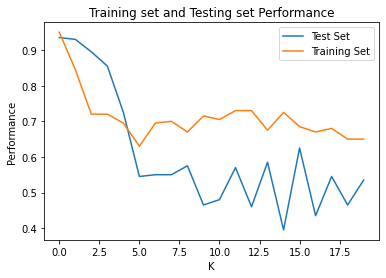

In [306]:
knn3(5,99)

In [303]:
# SCENARIO Three 
def knn4(k,flip):
    """ Takes in 2 arguments, k is a integer and flip a noise value which is between 0 and 100"""
    D = 2
    m = 0.9
    q = 0
    low_D = -10
    high_D = 10
    #Generate a test set without noise 
    Xte, Yte = linearBinaryClass(300, low_D, high_D, m, q)
    
    Ypredt = []
    Ypredtrl = []
    
    for i in range(30,301,30):
        print(i)
        # Generate a training set WITH NOISE
        Xtr, Ytr = linearBinaryClass(i, low_D, high_D, m, q)
        Yn = flipLabels(Ytr, flip)
        Ytr=Yn
        
        # Evaluate the NN classifier on the Training set
        Ypred = kNNClassify(Xtr, Ytr, k , Xte)
        
        # Classifier on the training set
        Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
        
        # Compute the accuracy on the TEST SET
        acc = calcAccuracy(Ypred, Yte)
        Ypredt.append(acc)
        
        print("With K={}, Noise={} and Training_set n={} the accuracy on the test set is ".format(k,flip,i), acc)
        # How the classifier perform on the TRAINING SET instead?
        Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
        acctr = calcAccuracy(Ypredtr, Ytr)
        Ypredtrl.append(acctr)
        print("With K={},  Noise={} and Training_set n={} the accuracy on the training set is ".format(k,flip,i), acctr)         
    xi = list(range(30,301,30))
    plt.plot(xi,Ypredt, label='Test Set')    
    plt.plot(xi,Ypredtrl, label='Training Set')
    plt.xlabel('Training set')
    plt.ylabel('Performance')
    plt.title('Training set and Testing set Performance')
    plt.legend()

30
With K=7, Noise=10 and Training_set n=30 the accuracy on the test set is  0.9166666666666666
With K=7,  Noise=10 and Training_set n=30 the accuracy on the training set is  0.9
60
With K=7, Noise=10 and Training_set n=60 the accuracy on the test set is  0.9433333333333334
With K=7,  Noise=10 and Training_set n=60 the accuracy on the training set is  0.8666666666666667
90
With K=7, Noise=10 and Training_set n=90 the accuracy on the test set is  0.8733333333333333
With K=7,  Noise=10 and Training_set n=90 the accuracy on the training set is  0.8555555555555555
120
With K=7, Noise=10 and Training_set n=120 the accuracy on the test set is  0.9333333333333333
With K=7,  Noise=10 and Training_set n=120 the accuracy on the training set is  0.8666666666666667
150
With K=7, Noise=10 and Training_set n=150 the accuracy on the test set is  0.9466666666666667
With K=7,  Noise=10 and Training_set n=150 the accuracy on the training set is  0.8933333333333333
180
With K=7, Noise=10 and Training_set

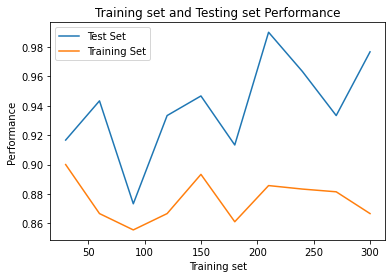

In [304]:
knn4(7,10)